# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Jacqueline Brown

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#! pip install keras
#! pip install tensorflow
#from keras.models import Sequential
#from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes_copy.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head(20)

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3
73585,0.0,0.728346,0.0,-3.078499,-0.568844,-0.268620,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,1
73587,0.0,1.288046,0.0,0.324834,2.754971,0.634362,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,1.138766,2.065262,1.125008,0.0,0.480384,1.087115,1.463404,-1.632812,3
73595,0.0,0.914913,0.0,0.324834,-0.044031,-1.171601,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,1.138766,-0.484200,1.125008,0.0,0.480384,1.087115,1.463404,0.612440,1
73596,0.0,-0.857470,0.0,0.324834,-0.481375,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,-0.888883,0.0,0.480384,-0.919866,-0.683338,0.612440,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

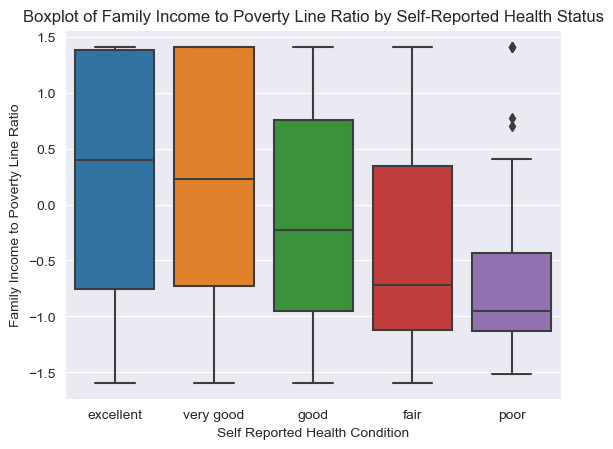

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

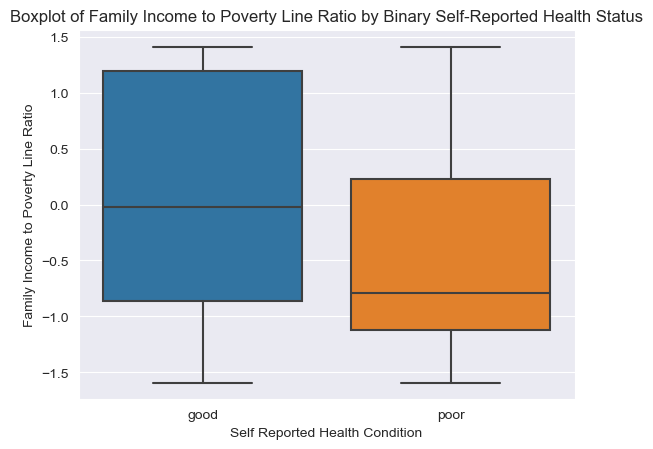

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

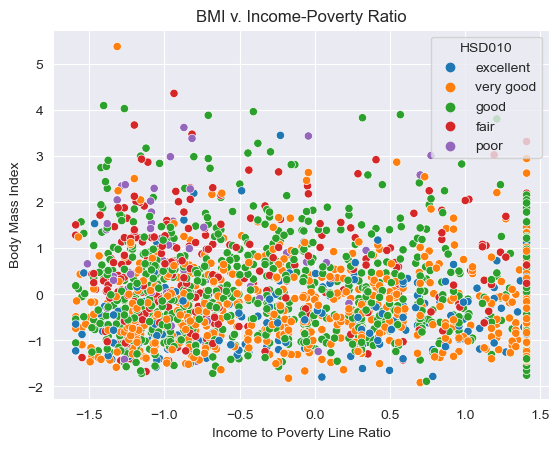

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [7]:
# apply PCA
# ----------
pca = PCA(n_components=2)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

# convert into a dataframe
# ----------
pca_df = pd.DataFrame(data = principalComponents_nhanes, 
                      columns = ['principal component 1', 
                                 'principal component 2'])

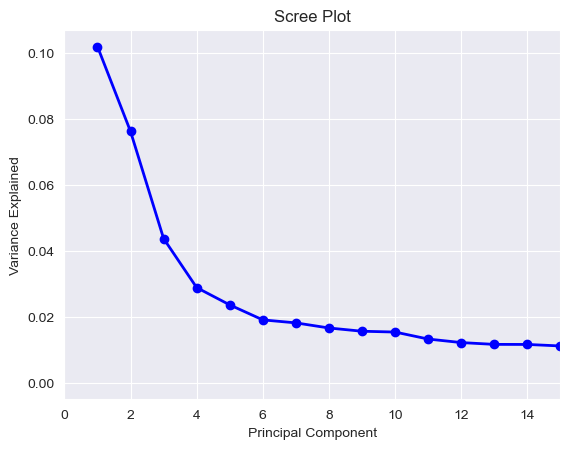

In [8]:
# Create a Scree plot to evaluate the number of components to keep
# --------------------------------------------------

# fit PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes = pca_all.fit_transform(nhanes_scaled)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xlim(0, 15)

plt.show()

Based on the scree plot, I am selecting 6 principal components. 

In [9]:
# apply PCA
# ----------
pca = PCA(n_components=6)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

# convert into a dataframe
# ----------
pca_df = pd.DataFrame(data = principalComponents_nhanes, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                'principal component 3', 
                                 'principal component 4',
                                'principal component 5', 
                                 'principal component 6'])


### Barplot of Components

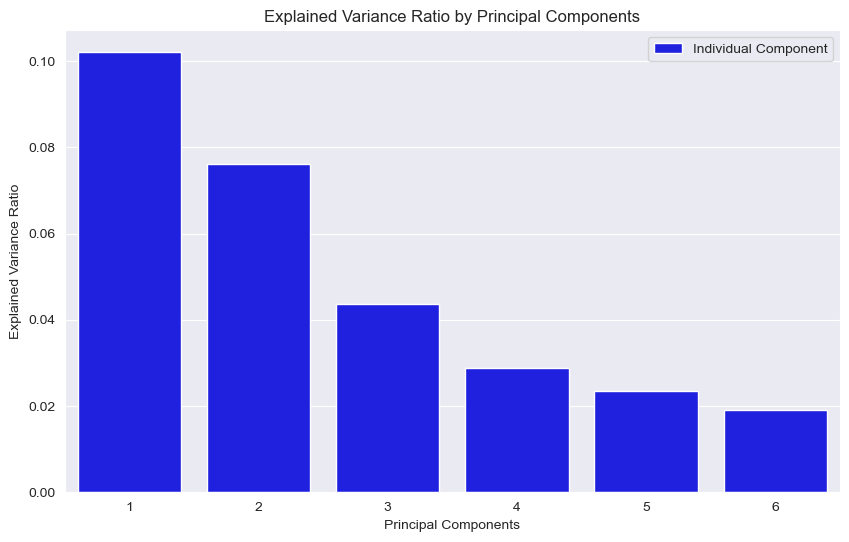

In [10]:
explained_var_ratio = pca.explained_variance_ratio_

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(explained_var_ratio) + 1), y=explained_var_ratio, color='blue', label='Individual Component')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')
plt.legend()
plt.show()

### How many components will you use to fit a supervised learning model?

I will keep all 6 components, in line with the scree plot elbow at PC # 6.


### 2D Scatterplot of the first two components

<Figure size 640x480 with 0 Axes>

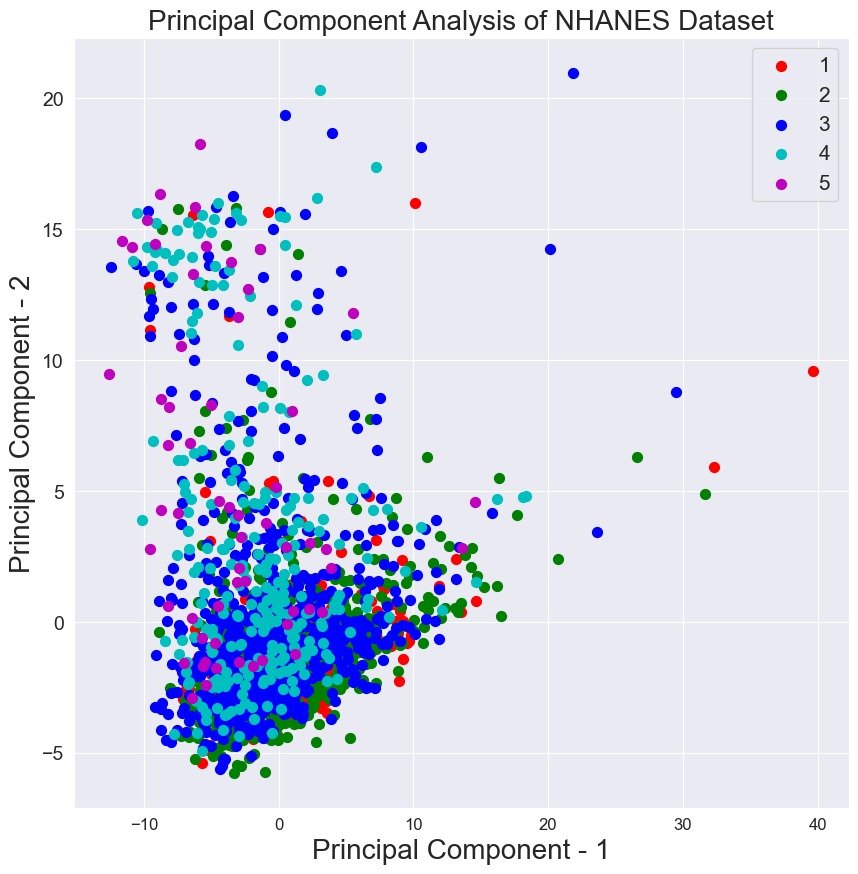

In [11]:
# plot
# ----------

# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES Dataset",fontsize=20)
targets = [1, 2, 3, 4, 5]
colors = ['r', 'g', 'b', 'c', 'm']

# loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    indicesToKeep = hsd010 == target
    indicesToKeep_reset = indicesToKeep.reset_index(drop=True)  # Reset index for alignment
    plt.scatter(pca_df.loc[indicesToKeep_reset, 'principal component 1'],
                pca_df.loc[indicesToKeep_reset, 'principal component 2'], c=color, s=50)

# show figure
plt.legend(targets, prop={'size': 15})
plt.show()

Based on this scatter plot of the principal components, there appears to be a lot of overlap in the clusters. There is a concentration of most of the clusters in the bottom left corner, but two components is not suffiecient to separate the clusters. 

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm


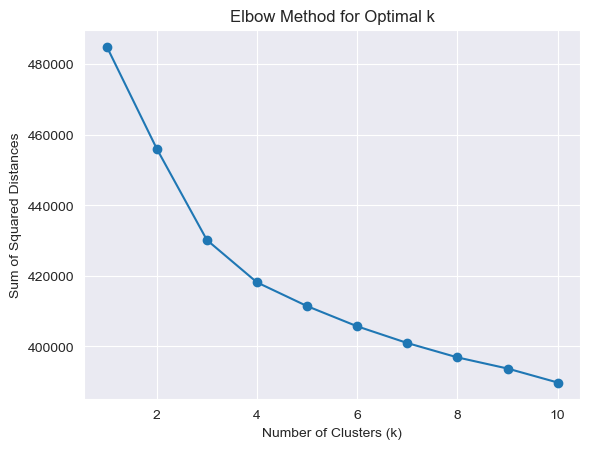

In [12]:
# Specify a range of k values
k_values = range(1, 11)

# Run k-means for each k and store the inertia in a list
inertia = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(nhanes_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

I chose a k-means clustering algorithm, which partitions data into a pre-specified number of clusters and minimizes the Euclidian distance between points and the centroid of the cluster. Based on this elbow plot, I'm selecting 4 clusters to apply the k-means clustering to the NHANES data. While this doesn't match with the 5 health categories, it makes sense given the distribution overlap of "Excellent" and "Very Good" categories in the box plot of Income Poverty Ratio.

### Cluster nhanes

In [13]:
# set random seed
np.random.seed(10)

# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [14]:
# New data frame, based on data above
nhanes_cluster = nhanes
nhanes_cluster_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes_cluster),
                             columns = nhanes_cluster.columns)
# Add the ID and target back in
nhanes_cluster_scaled['SEQN'] = seqn
nhanes_cluster_scaled['HSD010'] = hsd010
nhanes_cluster_scaled = nhanes_cluster_scaled.set_index('SEQN')

# add k-means result
nhanes_cluster_scaled['kmeans'] = kmeans.labels_

nhanes_cluster_scaled.head(20)


,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010,kmeans
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1,0
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1,2
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2,1
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2,1
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3,2
73585,0.0,0.728346,0.0,-3.078499,-0.568844,-0.268620,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,1,0
73587,0.0,1.288046,0.0,0.324834,2.754971,0.634362,-0.194202,-0.057306,0.128246,-0.189513,...,1.138766,2.065262,1.125008,0.0,0.480384,1.087115,1.463404,-1.632812,3,2
73595,0.0,0.914913,0.0,0.324834,-0.044031,-1.171601,-0.194202,-0.057306,0.128246,-0.189513,...,1.138766,-0.484200,1.125008,0.0,0.480384,1.087115,1.463404,0.612440,1,1
73596,0.0,-0.857470,0.0,0.324834,-0.481375,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,-0.888883,0.0,0.480384,-0.919866,-0.683338,0.612440,3,1


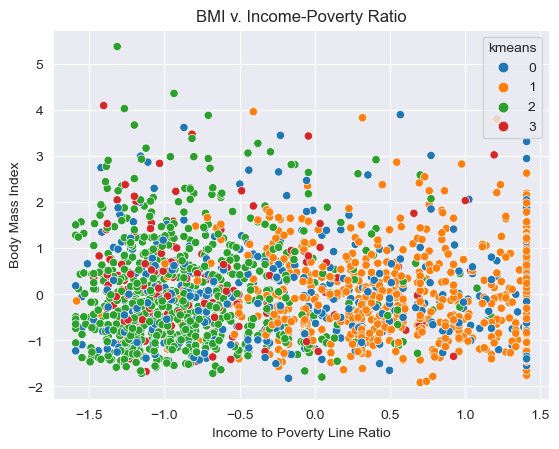

In [15]:
## Your Answer Here

ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "kmeans", palette = "tab10", data = nhanes_cluster_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()


## Your Answer Here
Above is a graph of the Income:Poverty Line ratio compared to BMI, colored by k-means cluster. The original graph, which is coded by health rating, is not nearly as clustered as the data above. In this case, Clusters 1 and 2 are separated across income, with the second cluster sitting below the poverty line. Cluster 0 is essentially distributed at random across this graph. Cluster 3 is somewhat randomly distributed as well, though skewed toward the lower-income portion of the spectrum.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [16]:
## Your Answer Here
# specify kmeans algorithm
# ----------
kmeans_pca = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(pca_df)

# add clusters and pca results to new data frame
pca_df_kmean = pca_df
pca_df_kmean["kmean"] = kmeans_pca.labels_


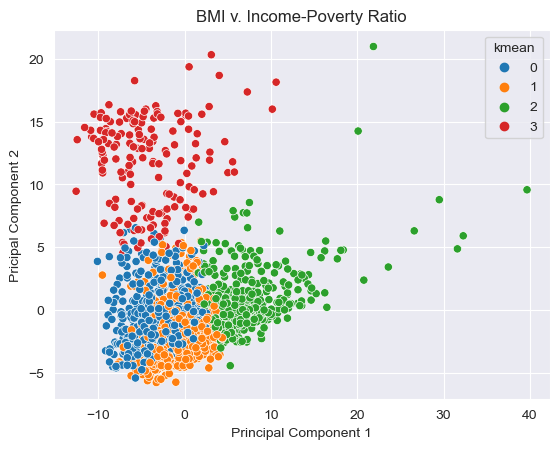

In [18]:
# plot
# ----------


ax = sns.scatterplot(x = "principal component 1", y = "principal component 2", hue = "kmean", palette = "tab10", data = pca_df)
ax.set(xlabel = "Principal Component 1",
      ylabel = "Pricipal Component 2")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()


## Your Answer Here

In this case, the clustering algorithm finds distinct clusters across PC 1 and 2 for clusters 2 and 3, while clusters 0 and 1 are somewhat intermingled in this graph. While it's clear that the outcome variable (health rating) is not clustered across either the principal components of the BMI vs Income:Poverty Line Ratio, the clustering algorithm is identifying clusters across other features. 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
# partition data
# -----------
y = ... # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = ... # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [ ]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = ...
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(..., ...)
y_test = keras.utils.to_categorical(..., ...)
num_classes = y_test.shape[1]

In [ ]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(..., input_dim= ..., kernel_initializer= ..., activation= ...))

model.add(Dense(..., kernel_initializer= ..., activation= ...))

## Add any additional layers you wish here

model.compile(loss= ..., optimizer= ..., metrics=[...])

model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"